# Detección de Fraude en Transacciones Bancarias


## Introducción y objetivo de negocio

En los bancos, el **fraude en tarjetas y transferencias** es uno de los eventos de riesgo operacional más importantes (categoría "External Fraud" de Basilea).

Objetivo del modelo:

> **Detectar el mayor número posible de fraudes reales con el menor número de alertas falsas**  
> (porque cada alerta falsa genera coste operativo y molestia al cliente)

Usaremos técnicas simples pero efectivas de Machine Learning.

---

Este modelo está diseñado para cumplir:
- Requerimientos Unidad de Análisis Financiero y Económico - UAFE de operaciones inusuales (Reporte de Operaciones o Transacciones Iguales o Superiores al Umbral Legal)
- Basilea II/III – External Fraud

Librerías


In [ ]:
# Librerias necesarias basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Librerías de Machine Learning
#!pip install -q imbalanced-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import shap

## 1. Carga de los datos

In [ ]:
# Se importa la base de datso
df = pd.read_excel('fraud_data.xlsx')
df.head()

,Unnamed: 0,fecha_hora,importe,cliente_id,comercio_categoria,tipo_transaccion,es_fraude
0,1,2024-02-25 06:41:00,63.29,1455,ropa,POS,0
1,2,2024-03-04 03:51:00,194.00,3722,restaurante,POS,0
2,3,2024-02-25 07:18:00,170.38,3236,farmacia,POS,0
3,4,2024-03-16 23:53:00,281.24,1534,supermercado,POS,0
4,5,2024-03-22 16:53:00,51.23,4348,farmacia,POS,0


In [ ]:
# Convertimos fecha_hora a datetime
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
# Ordenamos cronológicamente el dataset
df = df.sort_values(['cliente_id', 'fecha_hora']).reset_index(drop=True)
print(f"Dataset cargado: {len(df):,} transacciones")
print(f"Período: {df['fecha_hora'].min().date()} al {df['fecha_hora'].max().date()}")
print(f"Tasa de fraude: {df['es_fraude'].mean()*100:.4f}% ({df['es_fraude'].sum()} fraudes)")

Dataset cargado: 119,965 transacciones
Período: 2024-01-01 al 2024-03-24
Tasa de fraude: 0.2467% (296 fraudes)


## 2. Análisis exploratorio de datos

In [ ]:
#df.info()
#df.describe()

es_fraude
0    0.997533
1    0.002467
Name: proportion, dtype: float64


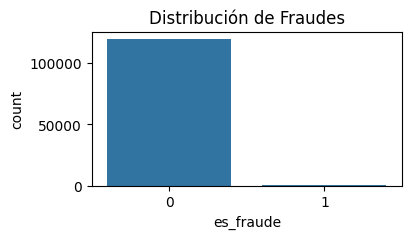

In [ ]:
# Variable objetivo 'es_fraude'
#df['es_fraude'].value_counts()
# Visualizamos la distribución
print(df['es_fraude'].value_counts(normalize=True))
plt.figure(figsize=(4,2))
sns.countplot(x='es_fraude', data=df)
plt.title('Distribución de Fraudes')
plt.show()

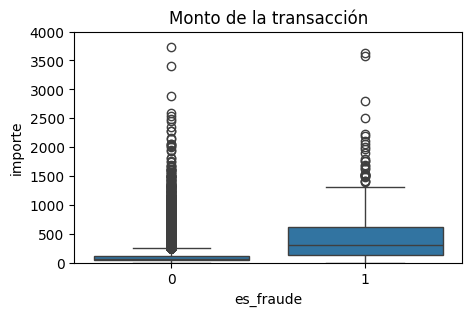

In [ ]:
# Monto de la transacción importe	vs. Fraude
plt.figure(figsize=(5, 3))
plt.title('Monto de la transacción')
sns.boxplot(x='es_fraude', y='importe', data=df)
plt.ylim(0, 4000);

## 3. Preparación de Datos para el Modelo - Ingeniería de variables (Feature Engineering)


**Creación de nuevas variables**

In [ ]:
def ingenieria_variables(df):
    df = df.copy()
    # Variables Temporales
    df['hora'] = df['fecha_hora'].dt.hour
    df['es_madrugada'] = df['hora'].isin([0,1,2,3,4,5]).astype(int)
    df['es_finde'] = df['fecha_hora'].dt.dayofweek.isin([5, 6]).astype(int)
    df['importe_log'] = np.log1p(df['importe'])

    # Variables de Velocidad (Rolling Window) - Usamos el índice temporal real.
    # Esto calcula EXACTAMENTE qué pasó en las últimas 24h reloj (no solo calendario).
    # Si son las 10:00 AM, mira hacia atrás hasta las 10:00 AM de ayer.

    # Seteamos el índice como fecha para poder usar '24h' como ventana
    df_indexed = df.set_index('fecha_hora').sort_index()

    # Agrupamos por cliente y aplicamos ventana rodante (rolling)
    grouped = df_indexed.groupby('cliente_id')['importe'].rolling('24h')

    # Count: Frecuencia transaccional
    df['tx_ultimas_24h'] = grouped.count().values

    # Sum: Monto acumulado (riesgo de vaciamiento)
    df['monto_acum_24h'] = grouped.sum().values

    # Al modelo no le importa que gastaste $800. Le importa que en las últimas 24 horas
    # has gastado el 500% de tu promedio habitual.
    df['importe_media_24h'] = grouped.mean().values
    df['ratio_vs_media_24h'] = df['importe'] / (df['importe_media_24h'] + 1)

    # Categorías de alto riesgo (sectores de mayor riesgo de fraude!!)
    alto_riesgo = ['electrónica', 'joyería', 'viajes', 'lujo']
    df['cat_alto_riesgo'] = df['comercio_categoria'].isin(alto_riesgo).astype(int)

    # C. Encoding de Categorías
    # Label Encoding (0,1,2,3) es malo para categorías nominales.
    # Usamos One-Hot Encoding (Variables Dummy).
    # Ejemplo: comercio_categoria_farmacia = 1, comercio_categoria_joyeria = 0

    df = pd.get_dummies(df, columns=['comercio_categoria', 'tipo_transaccion'], drop_first=True)

    # Limpieza de nulos generados por rolling (primeras tx)
    df = df.fillna(0)
    #df = df.reset_index()
    return df

In [ ]:
# Procesamos los datos (ingenieria) y generamos las variables
df_procesado = ingenieria_variables(df)
# Eliminamos columnas que no entran al modelo (fecha y IDs no sirven directo)
# Nota: En producción real, el ID del cliente puede servir para embeddings, pero aquí lo quitamos.
vars_a_eliminar = ['Unnamed: 0','fecha_hora', 'cliente_id', 'importe'] # Importe ya está en log y rolling
df_model = df_procesado.drop(columns=vars_a_eliminar)
print(f"Variables generadas: {df_model.shape[1]}")
df_model.head(3)

Variables generadas: 18


,es_fraude,hora,es_madrugada,es_finde,importe_log,tx_ultimas_24h,monto_acum_24h,importe_media_24h,ratio_vs_media_24h,cat_alto_riesgo,comercio_categoria_farmacia,comercio_categoria_gasolinera,comercio_categoria_joyería,comercio_categoria_restaurante,comercio_categoria_ropa,comercio_categoria_supermercado,comercio_categoria_viajes,tipo_transaccion_online
0,0,18,0,0,4.349245,1.0,76.42,76.42,0.987083,0,False,False,False,False,True,False,False,False
1,0,9,0,0,2.983660,1.0,18.76,18.76,0.949393,0,False,False,False,True,False,False,False,False
2,0,14,0,1,4.087152,1.0,58.57,58.57,0.983213,0,False,True,False,False,False,False,False,False


**División de Datos (Split Temporal)**

En banca no podemos predecir el fraude de "ayer" con datos de "mañana". El split aleatorio (train_test_split simple) es un error metodológico en series de tiempo.

In [ ]:
# Split Temporal (Time-based split)
# Entrenamos con los primeros meses, probamos con el último mes.

# Como ordenamos el DF al principio, podemos cortar por índice.
split_idx = int(len(df_model) * 0.8) # 80% train, 20% test

y = df_model['es_fraude']
X = df_model.drop('es_fraude', axis=1)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Escalado (Algunos modelos no lo exigen estrictamente, pero ayuda a SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]} transacciones")
print(f"Test: {X_test.shape[0]} transacciones")

Training: 95972 transacciones
Test: 23993 transacciones


## **4. Modelos**

**4.1 Modelo de Regresión logística**
---


In [ ]:
# Con balanceo de datos: class_weight='balanced',
modelo_lr = LogisticRegression(
    class_weight='balanced',  # Balanceo
)

modelo_lr.fit(X_train_scaled, y_train)
y_pred_lr = modelo_lr.predict(X_test_scaled)

# y_proba_lr = modelo_lr.predict_proba(X_test_scaled)[:, 1]
# y_pred_lr = (y_proba_lr >= 0.5 ).astype(int)

# Regresión Logística
cm_lr = confusion_matrix(y_test, y_pred_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
recall_lr = tp_lr / (tp_lr + fn_lr)

print(f" Fraudes detectados: {tp_lr}/{tp_lr+fn_lr} ({recall_lr:.1%}) | FP: {fp_lr:,} ({fp_lr/len(y_test)*100:.2f}%)")

 Fraudes detectados: 55/63 (87.3%) | FP: 3,440 (14.34%)


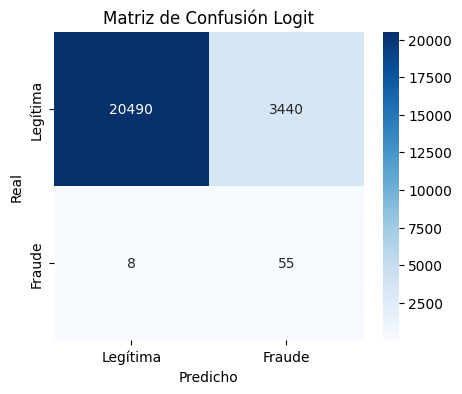

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legítima', 'Fraude'], yticklabels=['Legítima', 'Fraude'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión Logit')
plt.show()

In [ ]:
print(" REPORTE DE CLASIFICACIÓN ")
print(classification_report(y_test, y_pred_lr, target_names=['Legítima', 'Fraude']))

# Interpretación:
tn_lr, fp_lr, fn_lr, tp_lr = cm.ravel()
print(f"\nFraudes detectados: {tp_lr} de {tp_lr+fn_lr} ({tp_lr/(tp_lr+fn_lr)*100:.1f}%)")
print(f"Alertas falsas: {fp_lr} ({fp_lr/len(y_test)*100:.3f}% del total)")

 REPORTE DE CLASIFICACIÓN ... 
              precision    recall  f1-score   support

    Legítima       1.00      0.86      0.92     23930
      Fraude       0.02      0.87      0.03        63

    accuracy                           0.86     23993
   macro avg       0.51      0.86      0.48     23993
weighted avg       1.00      0.86      0.92     23993


Fraudes detectados: 55 de 63 (87.3%)
Alertas falsas: 3440 (14.338% del total)


In [ ]:
# ¿Qué variables son las más importantes?
# Coeficientes de la Regresión Logística

variables = X.columns.to_list()
coeficientes = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': modelo_lr.coef_[0],
    'Impacto': np.exp(modelo_lr.coef_[0])  # Odds ratio (fácil de explicar)
}).sort_values(by='Coeficiente', key=abs, ascending=False)

print("\n TOP VARIABLES MÁS IMPORTANTES (Regresión Logística)")
print("(Positivo = aumenta probabilidad de fraude)")
coeficientes


 TOP VARIABLES MÁS IMPORTANTES (Regresión Logística)
(Positivo = aumenta probabilidad de fraude)


,Variable,Coeficiente,Impacto
9,comercio_categoria_farmacia,-2.474959,0.084166
8,cat_alto_riesgo,1.755431,5.785942
15,comercio_categoria_viajes,-1.354446,0.258090
3,importe_log,0.572834,1.773285
6,importe_media_24h,0.504525,1.656198
10,comercio_categoria_gasolinera,0.493262,1.637649
16,tipo_transaccion_online,0.335499,1.398638
13,comercio_categoria_ropa,0.323230,1.381583
7,ratio_vs_media_24h,0.252559,1.287316
12,comercio_categoria_restaurante,0.099651,1.104785


**4.2 Entrenamiento del modelo (Random Forest + SMOTE)**

Imagina ahora que tienes un comité de 100 expertos (árboles). Cada uno hace preguntas de sí/no sobre los datos. Al final, votan. Si la mayoría dice "fraude", es fraude.

Usamos SMOTE para el balanceo de los datos: Como tenemos muy pocos fraudes (< 1\%), el modelo podría ignorarlos. SMOTE (Synthetic Minority Over-sampling Technique) crea "fraudes falsos" matemáticamente parecidos a los reales para entrenar al modelo, obligándolo a prestar atención a la clase minoritaria.

In [ ]:
# SMOTE crea transacciones "falsas" de fraude para balancear los datos

# modelo_rf = ImbPipeline([
#     ('smote', SMOTE(sampling_strategy=0.1)),
#     ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
# ])

modelo_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample',
                            max_depth=10, n_jobs=-1)

print("Entrenando el modelo... (Tarda de 20-60 segundos)")
modelo_rf.fit(X_train_scaled, y_train)
print("¡Modelo entrenado!")

Entrenando el modelo... (Tarda de 20-60 segundos)
¡Modelo entrenado!


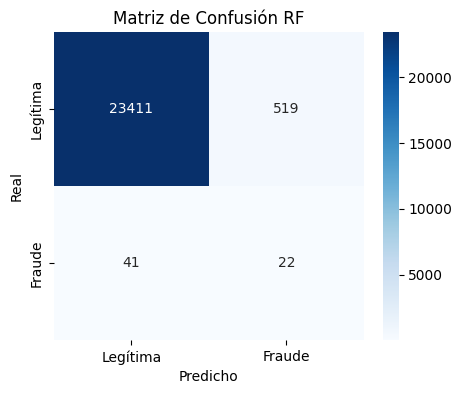

In [ ]:
# Predicciones
y_proba_rf = modelo_rf.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = modelo_rf.predict(X_test_scaled)
#y_pred_rf = (y_proba >= 0.5).astype(int)  # umbral inicial

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legítima', 'Fraude'], yticklabels=['Legítima', 'Fraude'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión RF')
plt.show()

In [ ]:
print(" REPORTE DE CLASIFICACIÓN ")
print(classification_report(y_test, y_pred_rf, target_names=['Legítima', 'Fraude']))

# Interpretación:
tn, fp, fn, tp = cm.ravel()
print(f"\nFraudes detectados: {tp} de {tp+fn} ({tp/(tp+fn)*100:.1f}%)")
print(f"Alertas falsas: {fp} ({fp/len(y_test)*100:.3f}% del total)")

 REPORTE DE CLASIFICACIÓN 
              precision    recall  f1-score   support

    Legítima       1.00      0.98      0.99     23930
      Fraude       0.04      0.35      0.07        63

    accuracy                           0.98     23993
   macro avg       0.52      0.66      0.53     23993
weighted avg       1.00      0.98      0.99     23993


Fraudes detectados: 22 de 63 (34.9%)
Alertas falsas: 519 (2.163% del total)


## **4.3 XGBoost**

Es una evolución de los árboles. En lugar de votar todos a la vez, los árboles se entrenan en secuencia. El árbol 2 se especializa en corregir los errores del árbol 1, el árbol 3 corrige al 2, etc. Este modelo es mucho más preciso y tiene parámetros como scale_pos_weight que están diseñados específicamente para datos desbalanceados.


In [ ]:
# Pipeline: Crear fraudes sintéticos (SMOTE) -> Entrenar XGBoost
# scale_pos_weight ayuda al modelo a prestar atención a la clase minoritaria
# sin necesidad de SMOTE agresivo, pero combinarlos suele dar buen resultado.

# ratio_desbalance = len(y_train[y_train==0]) / len(y_train[y_train==1])

# modelo_xgb = ImbPipeline([
#     ('smote', SMOTE(sampling_strategy=0.1)), # Generamos fraudes hasta el 10% del total (no 50/50 para no ensuciar)
#     ('xgb', XGBClassifier(
#         n_estimators=100,  #100
#         learning_rate=0.1,
#         max_depth=5, #5
#         scale_pos_weight=1,
#         n_jobs=-1,
#         eval_metric='logloss'
#     ))
# ])

scale_pos = (y_train==0).sum() / (y_train==1).sum()
modelo_xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1,
                    scale_pos_weight=scale_pos)

print("Entrenando modelo XGBoost...")
modelo_xgb.fit(X_train_scaled, y_train)

Entrenando modelo XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predicción final con el umbral calibrado
# Probabilidades
y_proba = modelo_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = modelo_xgb.predict(X_test_scaled)
#y_pred_xgb = (y_proba >= 0.5).astype(int)

# Reporte
print("RESULTADOS DEL MODELO XGB")
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()

print(f"Transacciones Legítimas Aprobadas: {tn}")
print(f"Fraudes Detectados (Recall):       {tp} de {tp+fn} ({(tp/(tp+fn))*100:.2f}%)")
print(f"Alertas Falsas (Molestia):         {fp} ({(fp/len(y_test))*100:.2f}% del tráfico total)")

RESULTADOS DEL MODELO XGB
Transacciones Legítimas Aprobadas: 23749
Fraudes Detectados (Recall):       20 de 63 (31.75%)
Alertas Falsas (Molestia):         181 (0.75% del tráfico total)



Matriz de Confusión:


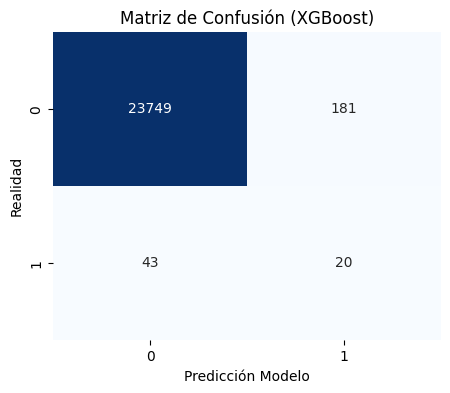

In [ ]:
print("\nMatriz de Confusión:")
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusión (XGBoost)")
plt.ylabel("Realidad")
plt.xlabel("Predicción Modelo")
plt.show()

También se peude buscar un umbral óptimo de clasificación

In [ ]:
# Búsqueda del Umbral Óptimo (F2 Score)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# F2 Score: Pondera el Recall (encontrar fraude) el doble que la Precisión (evitar molestar)
#           Esta es una métrica que valora encontrar fraudes el doble que la precisión.

f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-12)
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

print(f"Umbral óptimo sugerido: {best_threshold:.4f}")

# Predicción final con el umbral calibrado
y_pred_xgb = (y_proba >= best_threshold).astype(int)

# Reporte
print("RESULTADOS DEL MODELO XGB")
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()

print(f"Transacciones Legítimas Aprobadas: {tn}")
print(f"Fraudes Detectados (Recall):       {tp} de {tp+fn} ({(tp/(tp+fn))*100:.2f}%)")
print(f"Alertas Falsas (Molestia):         {fp} ({(fp/len(y_test))*100:.2f}% del tráfico total)")

Umbral óptimo sugerido: 0.8503
RESULTADOS DEL MODELO XGB
Transacciones Legítimas Aprobadas: 23875
Fraudes Detectados (Recall):       16 de 63 (25.40%)
Alertas Falsas (Molestia):         55 (0.23% del tráfico total)


## Comparación de modelos

In [ ]:
def obtener_metricas(y_true, y_pred, nombre):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn) if (tp+fn) > 0 else 0
    fp_rate = fp / (tn + fp) if (tn+fp) > 0 else 0
    return {'Modelo': nombre, 'Fraudes Detectados (Recall)': f"{recall:.1%}", 'Alertas Falsas (FPR)': f"{fp_rate:.2%}", 'TP': tp, 'FP': fp}

res_lr = obtener_metricas(y_test, y_pred_lr, "Regresión Logística")
res_rf = obtener_metricas(y_test, y_pred_rf, "Random Forest")
res_xgb = obtener_metricas(y_test, y_pred_xgb, "XGBoost")

df_resultados = pd.DataFrame([res_lr, res_rf, res_xgb])

print("TABLA COMPARATIVA DE MODELOS DE RIESGO")
print("-"*50)
print(df_resultados.to_string(index=False))


TABLA COMPARATIVA DE MODELOS DE RIESGO
--------------------------------------------------
             Modelo Fraudes Detectados (Recall) Alertas Falsas (FPR)  TP   FP
Regresión Logística                       87.3%               14.38%  55 3440
      Random Forest                       34.9%                2.17%  22  519
            XGBoost                       25.4%                0.23%  16   55


In [ ]:
## End ....